## Env

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
lake = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
# lake = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
lake.reset()

def make_dist_map(env):
    n = np.sqrt(env.observation_space.n)
    X, Y = np.meshgrid(np.arange(n,0,-1)-1, np.arange(n,0,-1)-1)
    return (X + Y).ravel()

dist_map = make_dist_map(lake)
dist_map

array([6., 5., 4., 3., 5., 4., 3., 2., 4., 3., 2., 1., 3., 2., 1., 0.])

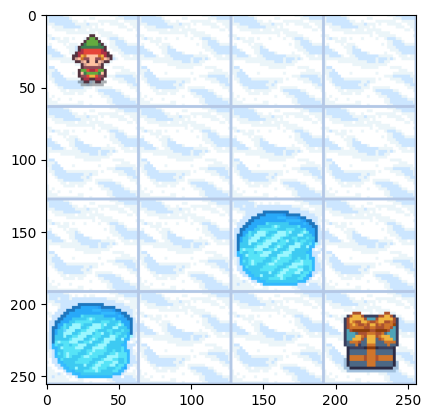

In [3]:
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


for _ in range(5):
    lake = gym.make('FrozenLake-v1', 
                    desc=generate_random_map(size=4, p=0.8),
                    map_name="4x4", is_slippery=False, render_mode="rgb_array")

    lake.reset()
    obs = lake.render()
    plt.imshow(obs)

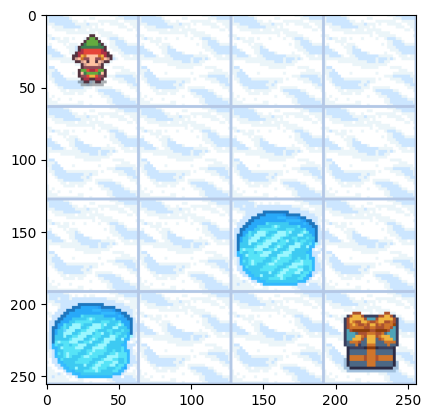

In [4]:
obs = lake.render()
plt.imshow(obs)

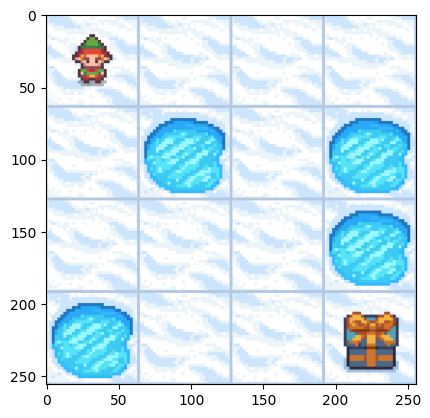

action: 1


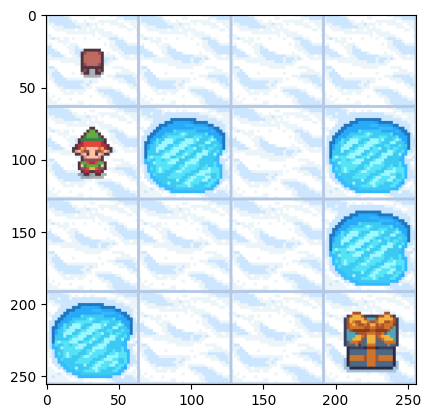

action: 1


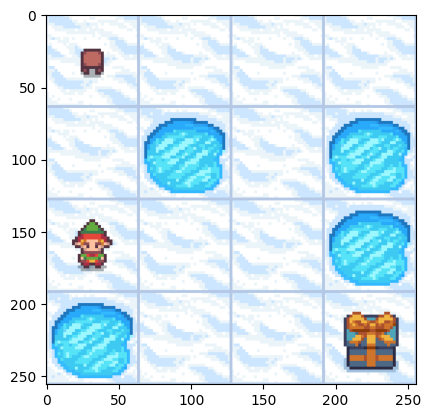

action: 2


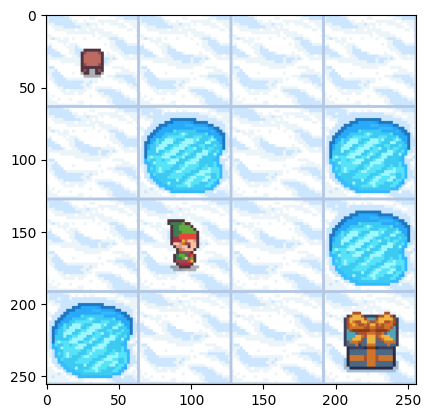

action: 2


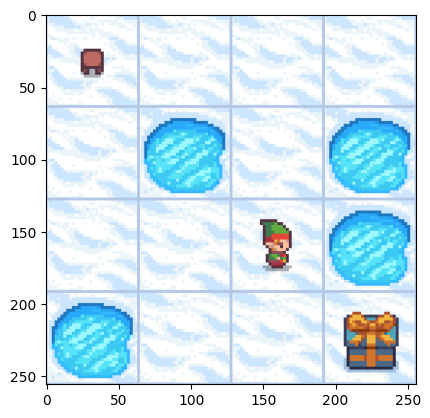

action: 1


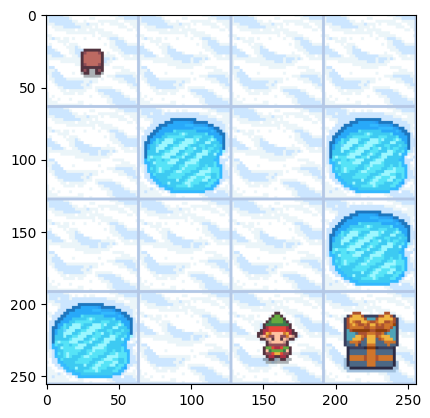

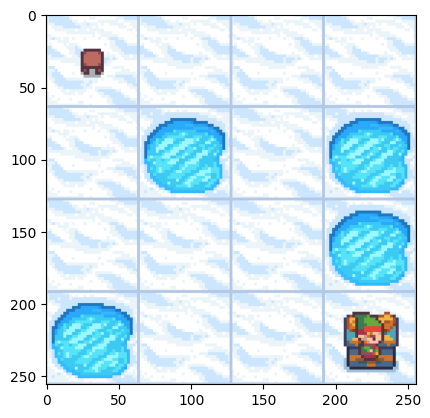

In [5]:
lake = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
new_state, _ = lake.reset()
obs = lake.render()
plt.imshow(obs)
plt.show()

for i in range(100):
    action = lake.action_space.sample()
    state = new_state
    new_state, reward, done, _, info = lake.step(action)
    if new_state != state:
        if done:
            if reward==0:
                new_state = state
                lake.env.env.env.s = state
            else:
                obs = lake.render()
                plt.imshow(obs)
                plt.show()
                break
        else:
            if dist_map[new_state]<dist_map[state]:
                print(f'action: {action}')
                obs = lake.render()
                plt.imshow(obs)
                plt.show()
            else:
                new_state = state
                lake.env.env.env.s = state

In [6]:
done, state, new_state, reward

(True, 14, 15, 1.0)

In [7]:
obs.shape

(256, 256, 3)

## Agent

## Q-Netrowk

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights


class DQN(nn.Module):
    def __init__(self,
                 input_shape = (256, 256, 3),
                 n_actions = 4,
                 device = 'cuda'):
        
        assert n_actions > 0 and type(n_actions) is int
        super().__init__()
        
        self.input_shape = input_shape
        self.n_actions = n_actions
        self._device = device
        
        w, h, c = self.input_shape
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        resnet.fc = nn.Linear(in_features=resnet.fc.in_features,
                              out_features=self.n_actions,
                              bias=True)
        resnet.to(device)
        self.resnet = resnet
        
    def _to(self, device):
        self.resnet.to(device)
        self._device = device
        
    def cuda(self):
        self._to('cuda')
        
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = obs_to_tensor(x)
        x = x.to(self._device)
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return self.resnet(x)
    

def obs_to_tensor(obs):        
    return torch.from_numpy(obs).permute(2, 0, 1) / 255

qnet = DQN()
# qnet

In [9]:
qnet(obs)[:,:4]

tensor([[ 0.1117,  0.0114, -0.0396, -0.0038]], device='cuda:0',
       grad_fn=<SliceBackward0>)

## Replay Memory

In [10]:
from collections import namedtuple, deque

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'terminated', 'truncated', 'env_s', 'env_new_s'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

## Training

In [12]:
import torch.optim as optim

In [13]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")

In [14]:
import random
import math

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

BATCH_SIZE = 16
GAMMA = 0.90
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations

policy_net = DQN(device=device)
target_net = DQN(device=device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def get_greedy_action(state):
    with torch.no_grad():
        # t.max(1) will return the largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return policy_net(state)[:,:4].max(1)[1].view(1, 1)

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return get_greedy_action(state)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
reward_history = []
reward_mean_history = []

def plot_durations(show_result=False):
    # plt.figure(1)
    fig, (ax_duration, ax_reward) = plt.subplots(2,1)
    ax_duration.set_ylabel('Duration')
    # ax_duration.set_xlabel('Episode')
    ax_reward.set_ylabel('Reward')
    ax_reward.set_xlabel('Episode')
    
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        # plt.title('Result')
        fig.suptitle('Result')
    else:
        # plt.clf()
        # plt.title('Training...')
        fig.suptitle('Training...')
    # plt.xlabel('Episode')
    # plt.ylabel('Duration')
    ax_duration.plot(durations_t.numpy())
    ax_duration.set_yscale('log')
    ax_duration.axhline(6, c='red', linestyle='dotted')
    
    # rewards = torch.cat(reward_history).detach().clone().to('cpu')
    ax_reward.plot(reward_history, label='reward',zorder=1)
    # rewards_means = torch.stack(reward_mean_history).to('cpu')
    ax_reward.plot(reward_mean_history, label='rolling mean(20)',zorder=0)
    ax_reward.legend()
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax_duration.plot(means.numpy())
    
    plt.close()
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            # display.display(plt.gcf())
            display.display(fig)
            display.clear_output(wait=True)
        else:
            # display.display(plt.gcf())
            display.display(fig)

In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [16]:
import time

time.time()

1681451535.5947373

Complete


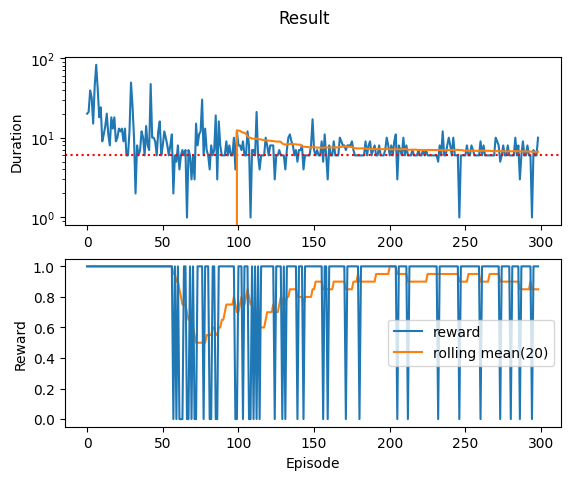

In [17]:
import matplotlib
import matplotlib.pyplot as plt
from itertools import count, islice


def one_play():
    walk_history = []
    desc = generate_random_map(size=4, p=0.8)
    env = gym.make('FrozenLake-v1', 
                   desc=generate_random_map(size=4, p=0.8),
                   map_name="4x4",
                   is_slippery=False,
                   render_mode="rgb_array")    
    
    _, info = env.reset()
    obs = env.render()
    result = dict(map = obs, desc=desc)
    
    state = obs_to_tensor(obs).unsqueeze(0).to(device)
    for t in count():
        if t > 20:
            break
        env_s = env.s
        walk_history.append(env_s)
        
        action = get_greedy_action(state)
        
        _, _reward, terminated, truncated, _ = env.step(action.item())
        env_new_s = env.s
        
        
        if terminated:
            next_state = None
        else:
            obs = env.render()
            next_state = obs_to_tensor(obs).unsqueeze(0).to(device)
            
        state = next_state
        
        done = terminated or truncated
        if done:
            break
        
    result['goal'] = _reward == 1
    result['walks'] = walk_history
    return result


def get_ng_desc():
    for t in count():
        result = one_play()
        if not result['goal'] :
            return result['desc']
        if t>100:
            return None

def get_ng_descs(n = 100):
    ng_descs = dict()
    bar = tqdm(total = n)
    while len(ng_descs)<n:
        ng_desc = get_ng_desc()
        key = ''.join([x for row in ng_desc for x in row])
        if key not in ng_descs:
            ng_descs[key] = ng_desc
            bar.update(1)
    return list(ng_descs.values())


def get_rollback_point():
    is_stop = False
    for tr in reversed(memory.memory):
        if tr.next_state is not None: 
            break
    return tr.next_state, tr.env_new_s


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

    
if torch.cuda.is_available():
    num_episodes = 300
else:
    num_episodes = 50

    
episode_durations = []
reward_history = []
reward_mean_history = []
memory = ReplayMemory(10000)

warmup_n_episodes = 50

walk_histories = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    desc = get_ng_desc()
    if desc is None:
        desc = generate_random_map(size=4, p=0.8)
        
    env = gym.make('FrozenLake-v1', 
                   # desc=generate_random_map(size=4, p=0.8),
                   desc=desc,
                   map_name="4x4",
                   is_slippery=False,
                   render_mode="rgb_array")    
    
    _, info = env.reset()
    obs = env.render()
    state = obs_to_tensor(obs).unsqueeze(0).to(device)
    
    walk_history = []
    for t in count():
        if t > 100:
            break
            
        action = select_action(state)
        env_s = env.s
        
        walk_history.append(env_s)
        _, _reward, terminated, truncated, _ = env.step(action.item())
        env_new_s = env.s
        
        done = terminated or truncated
        
        if done:
            if _reward==0: # Hole
                reward = -10
            else: # Goal
                reward = _reward * 10
        elif env_s == env_new_s: # No move
            reward = -1
        else:
            reward = 0.01
        
        reward = torch.tensor([reward], device=device)
        
        if terminated:
            next_state = None
        else:
            obs = env.render()
            next_state = obs_to_tensor(obs).unsqueeze(0).to(device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward, terminated, truncated, env_s, env_new_s)
        # if i_episode<warmup_n_episodes:
        #     if env_s != env_new_s:
        #         memory.push(state, action, next_state, reward, terminated, truncated, env_s, env_new_s)
        # else:
        #     memory.push(state, action, next_state, reward, terminated, truncated, env_s, env_new_s)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            if i_episode>=warmup_n_episodes:
                episode_durations.append(t + 1)

                reward_history.append(_reward)
                reward_mean = np.mean(reward_history[-20:])
                reward_mean_history.append(reward_mean)

                plot_durations()
                break
            else:
                if _reward>0:
                    episode_durations.append(t + 1)

                    reward_history.append(_reward)
                    reward_mean = np.mean(reward_history[-20:])
                    reward_mean_history.append(reward_mean)

                    if i_episode>0:
                        plot_durations()
                    break
                else:
                    # rollback
                    state, env_s = get_rollback_point()
                    env.env.env.env.s = env_s
                    

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()
# assert False

In [18]:
# assert False
# memory.memory

## test agent

In [19]:
observation_spaces = np.arange(lake.observation_space.n)
avaiable_spaces = observation_spaces[np.isin(lake.env.env.env.desc.ravel() , ( b'S', b'F'))]
avaiable_spaces

observations = []
for s in avaiable_spaces:
    lake.env.env.env.s = s
    obs = lake.render()
    observations.append(obs)

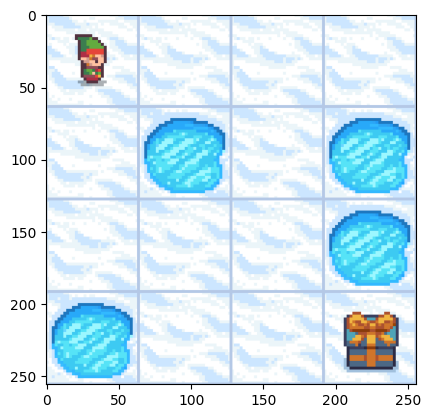

down tensor([[0.1517, 0.4520, 0.2683, 0.1281]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


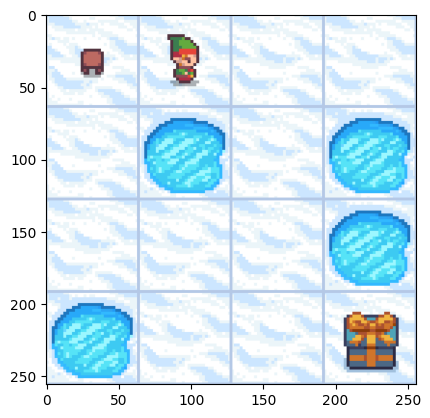

right tensor([[3.3559e-01, 7.7035e-05, 5.2767e-01, 1.3666e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


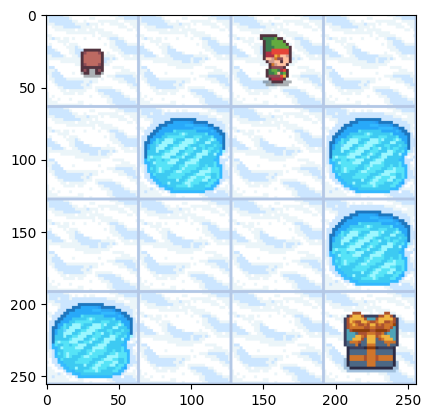

down tensor([[0.1980, 0.4229, 0.2734, 0.1057]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


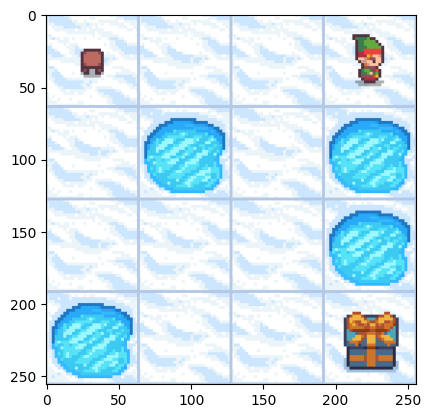

left tensor([[5.3668e-01, 2.7655e-04, 2.6338e-01, 1.9966e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


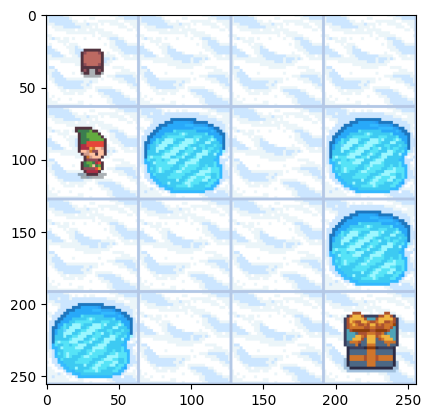

down tensor([[1.3926e-01, 6.5353e-01, 8.3443e-05, 2.0713e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


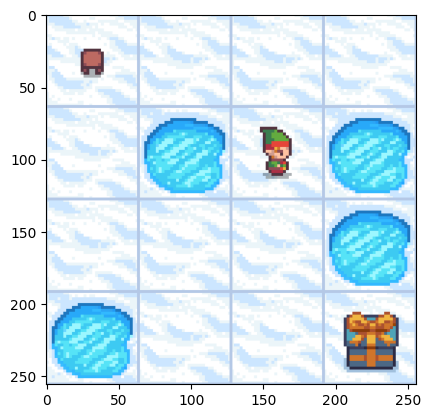

down tensor([[0.0044, 0.7005, 0.0007, 0.2944]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


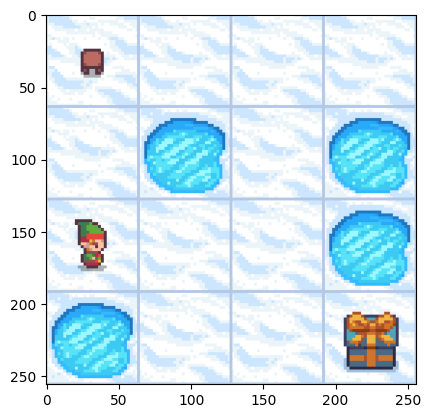

right tensor([[1.0623e-01, 7.4903e-05, 7.2186e-01, 1.7183e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


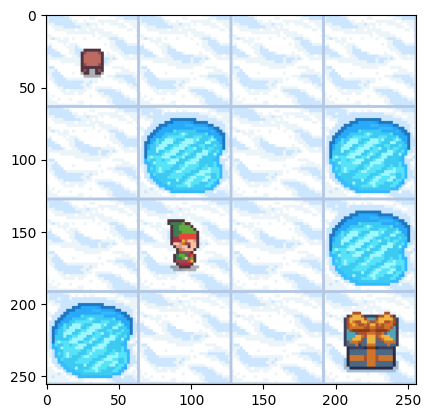

down tensor([[0.1013, 0.4879, 0.4101, 0.0008]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


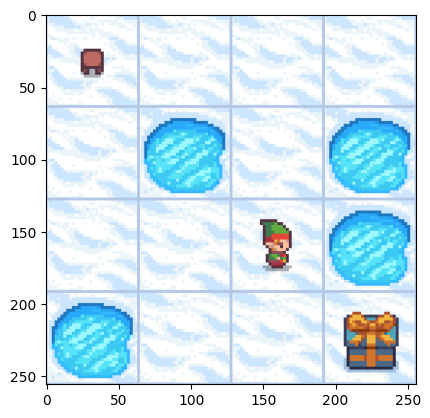

down tensor([[1.6448e-01, 7.6345e-01, 2.9321e-04, 7.1777e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


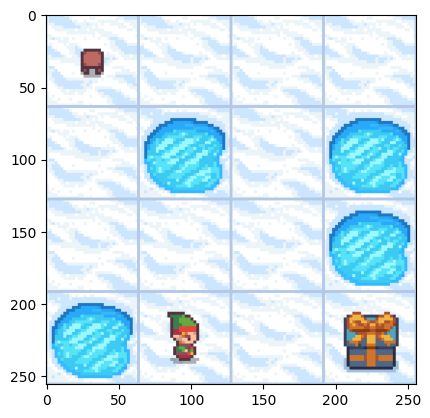

right tensor([[0.0009, 0.0591, 0.8229, 0.1171]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


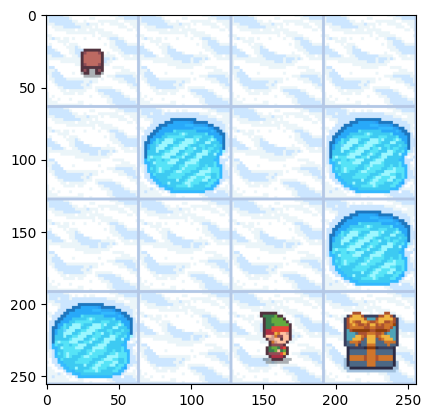

right tensor([[0.0843, 0.0809, 0.7998, 0.0350]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [20]:
actions = ['left', 'down', 'right', 'up']
for state in observations:
    plt.imshow(state)
    plt.show()
    
    action_prob = policy_net(state).softmax(1)
    action = actions[action_prob.max(1)[1].item()]
    print(action, action_prob)
    
# greedy_actions = [policy_net(state) for state in observations]
# # greedy_actions = [policy_net(state).max(1)[1].view(1, 1) for state in observations]
# greedy_actions

In [21]:
from tqdm.notebook import tqdm

        
def test_runs(n = 100):
    results = [one_play() for _ in tqdm(range(n))]
    goals_rate = np.mean([x['goal'] for x in results])
    n_walks = np.array([len(x['walks']) for x in results])
    return goals_rate, n_walks, results

goals_rate, n_walks, results = test_runs(n = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
ng_plays = [results[idx] for idx in np.argwhere(n_walks==100).ravel()]
for ng_play  in ng_plays:
    plt.imshow(ng_play['map'])
    plt.show()
    print(ng_play['walks'])